# Converting with `hls4ml`

## Setup

In [1]:

%load_ext autoreload
%autoreload 2


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

import hls4ml
import pickle

from PionReconstruction.util.Models import *
from PionReconstruction.util.Generators import *
from PionReconstruction.util.Plotting import *

## HLS Configuration

In [4]:
# Path to directory containing root files
data_path = '/fast_scratch_1/atlas_images/v01-45/'

# File with dictionary of cells' geometric information
cell_geo_path = data_path + 'cell_geo.root'

# The path to processed data and trained models
out_path = '/fast_scratch_1/jlerner/'

# The maximum number of cells used in the GarNet model
vmax = 128

# Whether the model is quantized with Qkeras
quantize = False
q = 'q' if quantize else ''

In [5]:
model = tf.keras.models.load_model(out_path + f'data/models/{q}GarNet_log_{vmax}')

# Specify the precision and reuse factor at the preferred granularity
config = {'Model': {'Precision': 'ap_fixed<27, 12>', 'ReuseFactor': 1, 'Strategy': 'Latency'},
          'LayerName': {'data': {'Precision': {'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}},
                        'vertex': {'Precision': {'result': 'ap_uint<16>'}},
                        'energy': {'Precision': {'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}}},
          'LayerType': {'GarNetStack': {'ReuseFactor': 1, 'Trace': True}},
          'Optimizers': ['eliminate_linear_activation']}

# Convert the model to HLS
hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, project_name=f'{q}_{vmax}',
                                                       output_dir=f'{out_path}GarNetHLS/{q}_{vmax}', 
                                                       part='xcu250-figd2104-2L-e')
# Compile the C++ model
hls_model.compile()


2023-08-25 09:15:56.387654: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-25 09:15:56.387717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6507 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5


Interpreting Model
Topology:
Layer name: data, layer type: InputLayer, input shapes: [[None, 32, 4]], output shape: [None, 32, 4]
Layer name: vertex, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: garnet, layer type: GarNetStack, input shapes: [[None, 32, 4], [None, 1]], output shape: [None, 16]
Layer name: energy, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: concatenate, layer type: Concatenate, input shapes: [[None, 16], [None, 1]], output shape: [None, 17]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 16]
Layer name: dense_2, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 8]
Layer name: classification, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 2]
Layer name: regression, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done


## Compare Performance

In [6]:
name = f'garnet_log_{vmax}'

test_file_list = ([[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] for i in range(232, 264)],
                  [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] for i in range(232, 264)])

test_generator = garnetDataGenerator(test_file_list,
                                     cell_geo_path,
                                     batch_size=20000,
                                     normalizer=('log', None),
                                     name=name,
                                     labeled=True,
                                     preprocess=False,
                                     output_dir=out_path + 'data/test/')

x, y = next(test_generator.generator())

keras_pred = model.predict(x)
hls_pred = hls_model.predict(x)

keras_scaled_pred = np.exp(keras_pred[-1]*10).reshape(-1,)
orig_pred = np.exp(x[2] * 10).reshape(-1,)
if hls_pred is not None:
    hls_scaled_pred = np.exp(hls_pred[-1]*10).reshape(-1,)
    scaled_target = np.exp(y['regression']*10).reshape(-1,)

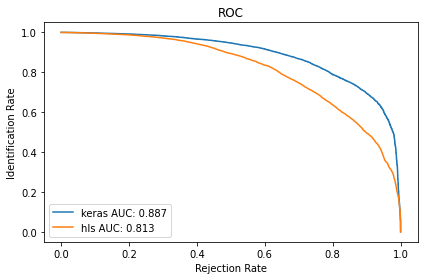

In [8]:
ROC = Plotter(roc, 
              preds=[keras_pred[0][:,0], hls_pred[0][:,0]],
              targets=[y['classification'][:,0], y['classification'][:,0]],
              labels=['keras', 'hls'])
ROC.show()

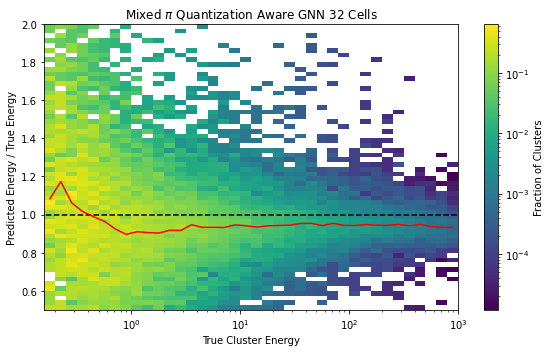

In [10]:
reg = Plotter(regResponse, 
              pred=keras_scaled_pred,
              target=scaled_target,
              stat=['median'],
              title=r'Mixed $\pi$' +  f' {q}GNN {vmax} Cells')

reg.show()

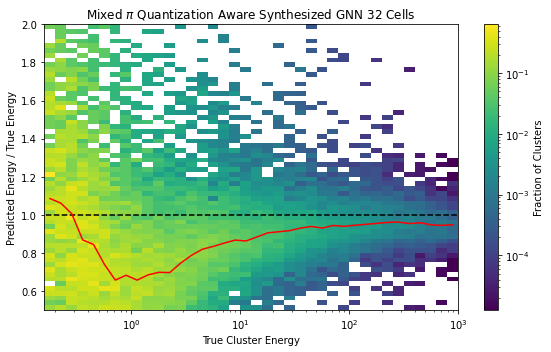

In [11]:
reg = Plotter(regResponse, 
              pred=hls_scaled_pred,
              target=scaled_target,
              stat=['median'],
              title=r'Mixed $\pi$' +  f' Synthesized {q}GNN {vmax} Cells')

reg.show()

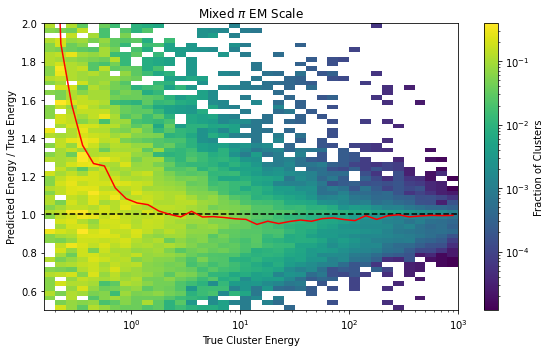

In [12]:
reg = Plotter(regResponse, 
              pred=orig_pred, 
              target=scaled_target,
              stat=['median'],
              title=r'Mixed $\pi$ EM Scale')
reg.show()

## Profile Precisions of Weights and Outputs

In [ ]:
prof = Plotter(weight_profile, model=model, hls_model=hls_model, x=x)
prof.show()